In [1]:
%load_ext autoreload
%autoreload 2

from imports import *
from dynamics import *
from model import *

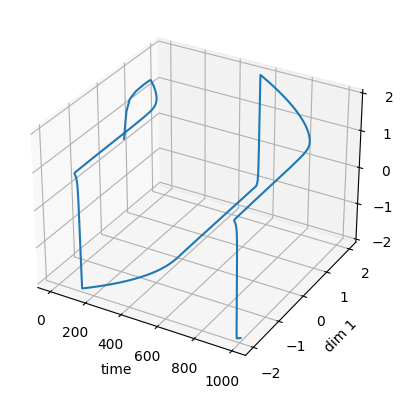

In [2]:
data = vdp_oscillator(dim=2, mu=25)

plot_3d(data.cpu().numpy())

In [3]:
def loss_fn(model, batch, num_negative_samples):
    margin = 0
    beta = 1

    '''
    positive term loss
    '''
    # E_x_tp1_positive - E_x_t
    min_difference = model(batch[1:, :]) - model(batch[:-1, :])

    positive_loss = 10 * torch.mean(
        torch.maximum(torch.zeros_like(min_difference).cuda(), min_difference)**2
    )

    '''
    negative samples: previous `num_negative_samples` in the trajectory given current x_t (i.e. x_{t - num_negative_samples} ... x_{t-1})
    '''
    negative_loss = []

    for i in range(batch.shape[0]-1):
        num_samples = min(i, num_negative_samples)

        if num_samples:
            # E_x_tp1_negative - E_x_t
            max_difference = model(batch[np.random.choice(i, size=(num_samples,), replace=False), :]) - model(batch[i, :].unsqueeze(0)).repeat(num_samples)
            
            '''
            hinge loss with margin
            '''
            loss = torch.sum(
                torch.maximum(torch.zeros_like(max_difference).cuda(), -max_difference)**2 + \
                torch.minimum(torch.zeros_like(max_difference).cuda(), -max_difference/10)
            )

            '''
            Gibbs partition function based loss
            '''
            # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * (difference))))

            '''
            negative exponential loss
            '''
            # loss = torch.sum(torch.exp(-(difference)))

            negative_loss.append(loss)

    '''
    different way to generate negative samples:
        create a hypersphere of radius || E_x_tp1 - E_x_t ||
        pick vectors in that hypersphere that are `angle` away from vector E_x_tp1 - E_x_t
    '''
    # for i in range(batch.shape[0]-1):
    #     E_x_t = model(batch[i, :].unsqueeze(0)).repeat(num_negative_samples)
    #     E_x_tp1 = model(generate_negative_samples(batch[i, :], angle=45, num_samples=num_negative_samples))
    
    #     difference = E_x_tp1 - E_x_t
    #     difference[difference.abs() > 5e-4] = difference
    
    #     loss = torch.sum(torch.maximum(torch.zeros(num_negative_samples).cuda(), margin - (difference))**2)
    #     # loss = 1/beta * torch.log(torch.sum(torch.exp(-beta * (difference))))
    #     # loss = torch.sum(torch.exp(-(difference)))

    #     losses.append(loss)

    return positive_loss + sum(negative_loss)/len(negative_loss)


def plot_energy_along_trajectory(model, trajectory):
    with torch.no_grad():
        E_x_t = []

        for x_t in trajectory:
            E_x_t.append(model(x_t.unsqueeze(0)).squeeze().detach().cpu().item())

    plt.plot(E_x_t)
    plt.title("energy along trajectory")

    plt.show()


def plot_energy_landscape(model):
    X = torch.linspace(-10, 10, steps=500)
    Y = torch.linspace(-10, 10, steps=500)

    energy_manifold = model(torch.cartesian_prod(X, Y).cuda()).reshape(X.shape[0], Y.shape[0]).detach().cpu().numpy()

    X, Y = np.meshgrid(X.numpy(), Y.numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    surface = ax.plot_surface(X, Y, energy_manifold, cmap='viridis', edgecolor='k', linewidth=0.5, facecolor=(1,1,1,0.2))

    fig.colorbar(surface, pad=0.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$energy$')
    ax.set_title('energy landscape')
    
    plt.show()


def epoch(iterations, model, optimizer, data, bs, num_negative_samples):
    losses = []

    for i in range(iterations):
        batch = generate_batch(data, bs=bs)

        optimizer.zero_grad()

        loss = loss_fn(model, batch, num_negative_samples=num_negative_samples)

        loss.backward()

        optimizer.step()

        losses.append(loss.detach().cpu().item())

    return np.mean(losses)

  1%|          | 1/100 [00:08<14:18,  8.67s/it]

-3.097629487514496


  2%|▏         | 2/100 [00:17<13:54,  8.52s/it]

2.4698516964912414


  3%|▎         | 3/100 [00:25<13:34,  8.40s/it]

2.1967483520507813


  4%|▍         | 4/100 [00:33<13:21,  8.35s/it]

-0.5059809684753418


  5%|▌         | 5/100 [00:41<13:10,  8.32s/it]

3.267305326461792


  6%|▌         | 6/100 [00:50<13:02,  8.33s/it]

-0.3936907291412354


  7%|▋         | 7/100 [00:58<12:51,  8.29s/it]

8.749465799331665


  8%|▊         | 8/100 [01:06<12:42,  8.28s/it]

-0.879542076587677


  9%|▉         | 9/100 [01:14<12:32,  8.27s/it]

0.5481445252895355


 10%|█         | 10/100 [01:23<12:22,  8.25s/it]

-0.8227278094738721


 11%|█         | 11/100 [01:31<12:13,  8.24s/it]

-0.5550928436219692


 12%|█▏        | 12/100 [01:39<12:04,  8.23s/it]

-0.6257645189762115


 13%|█▎        | 13/100 [01:47<11:55,  8.22s/it]

-0.9526771783828736


 14%|█▍        | 14/100 [01:55<11:45,  8.21s/it]

-0.45260793566703794


 15%|█▌        | 15/100 [02:04<11:36,  8.19s/it]

-0.9935826525092125


 16%|█▌        | 16/100 [02:12<11:26,  8.17s/it]

-0.7690826654434204


 17%|█▋        | 17/100 [02:20<11:17,  8.17s/it]

-1.2936949253082275


 18%|█▊        | 18/100 [02:28<11:10,  8.17s/it]

-0.017408087849617004


 19%|█▉        | 19/100 [02:36<11:01,  8.17s/it]

0.07397308750078083


 20%|██        | 20/100 [02:44<10:52,  8.16s/it]

-0.2433208256959915


 21%|██        | 21/100 [02:53<10:44,  8.15s/it]

-1.0375273317098617


 22%|██▏       | 22/100 [03:01<10:35,  8.15s/it]

0.8257694356143475


 23%|██▎       | 23/100 [03:09<10:30,  8.19s/it]

0.3438900649547577


 24%|██▍       | 24/100 [03:17<10:22,  8.19s/it]

-0.37163211959414183


 25%|██▌       | 25/100 [03:25<10:17,  8.23s/it]

-0.394403488188982


 26%|██▌       | 26/100 [03:34<10:08,  8.23s/it]

-0.2705876544117928


 27%|██▋       | 27/100 [03:42<09:58,  8.20s/it]

-0.7704722735565156


 28%|██▊       | 28/100 [03:50<09:51,  8.21s/it]

0.41274182200431825


 29%|██▉       | 29/100 [03:58<09:41,  8.19s/it]

-0.4880515396595001


 30%|███       | 30/100 [04:06<09:33,  8.19s/it]

-0.7249281287193299


 31%|███       | 31/100 [04:15<09:24,  8.19s/it]

-0.559947395324707


 32%|███▏      | 32/100 [04:23<09:16,  8.19s/it]

-1.1523686692118644


 33%|███▎      | 33/100 [04:31<09:08,  8.19s/it]

-2.071517026424408


 34%|███▍      | 34/100 [04:39<09:01,  8.20s/it]

-2.3633414268493653


 35%|███▌      | 35/100 [04:47<08:52,  8.20s/it]

-3.000694191455841


 36%|███▌      | 36/100 [04:56<08:43,  8.18s/it]

3.974122929573059


 37%|███▋      | 37/100 [05:04<08:36,  8.20s/it]

-1.1396995216608048


 38%|███▊      | 38/100 [05:12<08:30,  8.24s/it]

-1.6915125370025634


 39%|███▉      | 39/100 [05:20<08:24,  8.27s/it]

-0.6918943375349045


 40%|████      | 40/100 [05:29<08:14,  8.24s/it]

-0.05274316668510437


 41%|████      | 41/100 [05:37<08:06,  8.24s/it]

-2.228691065311432


 42%|████▏     | 42/100 [05:45<07:56,  8.21s/it]

-0.5289857350289822


 43%|████▎     | 43/100 [05:53<07:46,  8.19s/it]

0.6751881241798401


 44%|████▍     | 44/100 [06:01<07:37,  8.18s/it]

-0.9412631690502167


 45%|████▌     | 45/100 [06:09<07:29,  8.17s/it]

-0.7589776538312435


 46%|████▌     | 46/100 [06:18<07:20,  8.16s/it]

-0.5015444278717041


 47%|████▋     | 47/100 [06:26<07:13,  8.18s/it]

-0.7019676804542542


 48%|████▊     | 48/100 [06:34<07:08,  8.23s/it]

-0.8162783086299896


 49%|████▉     | 49/100 [06:42<06:57,  8.18s/it]

-0.6416352748870849


 50%|█████     | 50/100 [06:50<06:48,  8.17s/it]

-0.5130315490067006


 51%|█████     | 51/100 [06:58<06:38,  8.12s/it]

-0.7081743072718382


 52%|█████▏    | 52/100 [07:06<06:28,  8.08s/it]

-1.534169372683391


 53%|█████▎    | 53/100 [07:14<06:19,  8.08s/it]

-0.6377762079238891


 54%|█████▍    | 54/100 [07:22<06:10,  8.05s/it]

-0.73330659866333


 55%|█████▌    | 55/100 [07:30<06:01,  8.03s/it]

-1.2804506942629814


 56%|█████▌    | 56/100 [07:38<05:53,  8.03s/it]

-1.5938441395759582


 57%|█████▋    | 57/100 [07:46<05:45,  8.03s/it]

1.1163787245750427


 58%|█████▊    | 58/100 [07:55<05:37,  8.04s/it]

-0.4414346903562546


 59%|█████▉    | 59/100 [08:03<05:29,  8.04s/it]

-0.6298290140926838


 60%|██████    | 60/100 [08:11<05:21,  8.04s/it]

-0.4267611175775528


 61%|██████    | 61/100 [08:19<05:13,  8.03s/it]

0.4155766606330872


 62%|██████▏   | 62/100 [08:27<05:05,  8.03s/it]

-0.8635612547397613


 63%|██████▎   | 63/100 [08:35<04:57,  8.03s/it]

-0.301801997423172


 64%|██████▍   | 64/100 [08:43<04:48,  8.02s/it]

-0.33996457159519194


 65%|██████▌   | 65/100 [08:51<04:41,  8.05s/it]

-0.9113437503576278


 66%|██████▌   | 66/100 [08:59<04:35,  8.10s/it]

-0.6692851275205612


 67%|██████▋   | 67/100 [09:07<04:28,  8.13s/it]

-1.2885124266147614


 68%|██████▊   | 68/100 [09:15<04:20,  8.15s/it]

-1.6308725476264954


 69%|██████▉   | 69/100 [09:24<04:12,  8.15s/it]

-2.1691649079322817


 70%|███████   | 70/100 [09:32<04:04,  8.15s/it]

-1.2203865826129914


 71%|███████   | 71/100 [09:40<03:56,  8.14s/it]

-3.6730825424194338


 72%|███████▏  | 72/100 [09:48<03:47,  8.13s/it]

-2.376770186424255


 73%|███████▎  | 73/100 [09:56<03:39,  8.13s/it]

0.6173997521400452


 74%|███████▍  | 74/100 [10:04<03:31,  8.14s/it]

-2.5978053331375124


 75%|███████▌  | 75/100 [10:12<03:23,  8.14s/it]

0.1158496581017971


 76%|███████▌  | 76/100 [10:20<03:15,  8.14s/it]

0.4885509252548218


 77%|███████▋  | 77/100 [10:29<03:07,  8.13s/it]

-0.3769874095916748


 78%|███████▊  | 78/100 [10:37<02:59,  8.15s/it]

-0.49013412296772


 79%|███████▉  | 79/100 [10:45<02:50,  8.14s/it]

-1.642070722579956


 80%|████████  | 80/100 [10:53<02:42,  8.15s/it]

-1.2080580472946167


 81%|████████  | 81/100 [11:01<02:34,  8.14s/it]

0.09179363250732422


 82%|████████▏ | 82/100 [11:09<02:26,  8.14s/it]

-0.7075318574905396


 83%|████████▎ | 83/100 [11:18<02:18,  8.15s/it]

-0.6174927175045013


 84%|████████▍ | 84/100 [11:26<02:10,  8.14s/it]

-1.1482032876461745


 85%|████████▌ | 85/100 [11:34<02:02,  8.15s/it]

-0.6621179103851318


 86%|████████▌ | 86/100 [11:42<01:54,  8.16s/it]

-1.2818803042173386


 87%|████████▋ | 87/100 [11:50<01:45,  8.11s/it]

-1.591070219874382


 88%|████████▊ | 88/100 [11:58<01:36,  8.08s/it]

1.7668586850166321


 89%|████████▉ | 89/100 [12:06<01:28,  8.07s/it]

-1.0307646930217742


 90%|█████████ | 90/100 [12:14<01:20,  8.07s/it]

-1.223560059070587


 91%|█████████ | 91/100 [12:22<01:12,  8.04s/it]

-0.9762156486511231


 92%|█████████▏| 92/100 [12:30<01:04,  8.04s/it]

-0.8590574562549591


 93%|█████████▎| 93/100 [12:38<00:56,  8.04s/it]

0.9511993765830994


 94%|█████████▍| 94/100 [12:46<00:48,  8.03s/it]

-1.3133347906172275


 95%|█████████▌| 95/100 [12:54<00:40,  8.03s/it]

-1.5090618133544922


 96%|█████████▌| 96/100 [13:02<00:32,  8.04s/it]

-0.5015730410814285


 97%|█████████▋| 97/100 [13:10<00:24,  8.05s/it]

-1.6104721307754517


 98%|█████████▊| 98/100 [13:18<00:16,  8.05s/it]

-1.3151398956775666


 99%|█████████▉| 99/100 [13:26<00:08,  8.05s/it]

-1.2082028463482857


100%|██████████| 100/100 [13:34<00:00,  8.15s/it]

3.5553889155387877


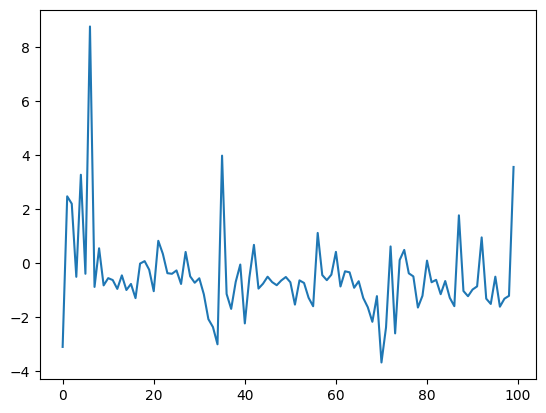

In [4]:
dim = 2

model = EBM(2).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

losses = []

for e in tqdm(range(100)):
    data = vdp_oscillator(dim=dim, mu=25)

    N = data.shape[0]
    # bs = np.random.randint(int(0.5 * N), N + 1)
    bs = int(0.5 * N)

    loss = epoch(iterations=10, model=model, optimizer=optimizer, data=data, bs=bs, num_negative_samples=int(bs * 0.5))
    losses.append(loss)
    print(loss)

plt.plot(losses)

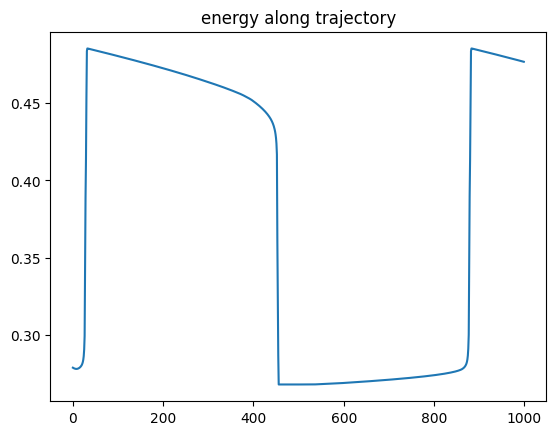

In [12]:
plot_energy_along_trajectory(model, vdp_oscillator(dim=dim, mu=25))

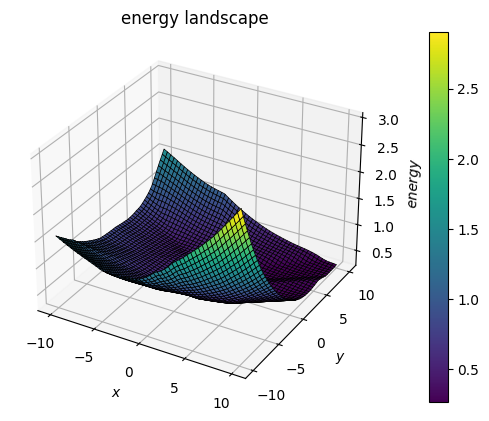

In [7]:
plot_energy_landscape(model)